In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# seeded for sampling in notebook
from bgflow.utils.types import pack_tensor_in_tuple

/Users/johannes/miniforge3/envs/bgflow/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def box(x):
    return 1000*(x/10).pow(10).sum(dim=-1, keepdim=True)

In [3]:
# define some plotting functions
from bgflow.utils.types import assert_numpy

def plot_energy(energy, extent=(-6, 6), resolution=100, dim=2):
    """ Plot energy functions in 2D """
    xs = torch.meshgrid([torch.linspace(*extent, resolution) for _ in range(2)])
    xs = torch.stack(xs, dim=-1).view(-1, 2)
    xs = torch.cat([
        xs,
        torch.Tensor(xs.shape[0], dim - xs.shape[-1]).zero_()
    ], dim=-1)
    us = (energy.energy(xs)+box(xs)).view(resolution, resolution)
    us = torch.exp(-us)
    plt.imshow(assert_numpy(us).T, extent=extent * 2)
    plt.xlim=(extent[0], extent[1])
    plt.ylim=(extent[0], extent[1])


def plot_samples(samples, weights=None, range=None):
    """ Plot sample histogram in 2D """
    samples = assert_numpy(samples)
    plt.hist2d(
        samples[:, 0], 
        -samples[:, 1],
        weights=assert_numpy(weights) if weights is not None else weights,
        bins=100,
        norm=mpl.colors.LogNorm(),
        range=range
    )
    
def plot_bg(bg, target, n_samples=10000, range=[-3, 3], dim=2):
    """ Plot target energy, bg energy and bg sample histogram"""
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plot_energy(target, extent=range, dim=dim)
    plt.title("Target energy")
    plt.subplot(1, 3, 2)
    plot_energy(bg, extent=range, dim=dim)
    plt.title("BG energy")
    plt.subplot(1, 3, 3)
    plot_samples(bg.sample(n_samples), range=[range, range])
    plt.title("BG samples")

def plot_weighted_energy_estimate(bg, target, n_samples=100000, extent=None, n_bins=100, range=[-3, 3], dim=2):
    """ Plot weighed energy from samples """
    samples, latent, dlogp = bg.sample(n_samples, with_latent=True, with_dlogp=True)
    log_weights = bg.log_weights_given_latent(samples, latent, dlogp)

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    _, bins, _ = plt.hist(assert_numpy(samples[:, 0]), histtype="step", log=True, bins=n_bins, weights=None, density=True, label="samples", range=range)
    xs = torch.linspace(*range, n_bins).view(-1, 1)
    xs = torch.cat([xs, torch.zeros(xs.shape[0], dim - 1)], dim=-1).view(-1, dim)
    us = target.energy(xs).view(-1)
    us = torch.exp(-us)
    us = us / torch.sum(us * (bins[-1] - bins[0]) / n_bins)
    plt.plot(xs[:, 0], us, label="$\log p(x)$")
    plt.xlabel("$x0$")
    plt.ylabel("log density")
    plt.legend()
    plt.title("unweighed energy")
    
    plt.subplot(1, 3, 2)
    _, bins, _ = plt.hist(assert_numpy(samples[:, 0]), histtype="step", log=True, bins=n_bins, weights=assert_numpy(log_weights.exp()), density=True, label="samples", range=range)
    plt.plot(xs[:, 0], us, label="$\log p(x)$")
    plt.xlabel("$x0$")
    plt.legend()
    plt.title("weighed energy")

    plt.subplot(1, 3, 3)
    plt.xlabel("$x0$")
    plt.ylabel("$x1$")
    plot_samples(samples, weights=log_weights.exp(), range=[range, range])
    plt.title("weighed samples")

/Users/johannes/miniforge3/envs/bgflow/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1664817728005/work/aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


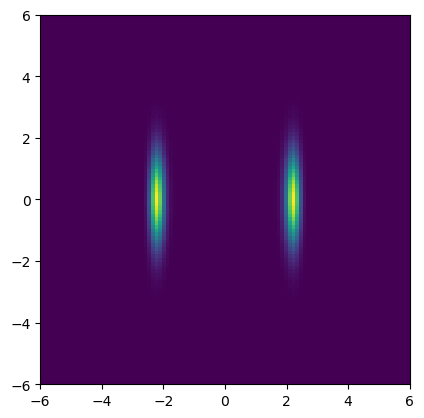

In [4]:
# define system: double well potential
from bgflow import DoubleWellEnergy
dim = 2
target = DoubleWellEnergy(dim, b=-10,c=1)
plot_energy(target, dim=dim)

In [5]:
# set up a prior
from bgflow import NormalDistribution
cov = torch.zeros((2,2), dtype=torch.float)
cov[0,0]=0.01
cov[1,1]=0.01
prior = NormalDistribution(2, cov=cov)

In [6]:
# define a flow with RNVP coupling layers (from example)
from bgflow.nn import (
    DenseNet,
    SequentialFlow, 
    CouplingFlow, 
    AffineFlow, 
    SplitFlow, 
    InverseFlow, 
    SwapFlow,
    AffineTransformer
)
# here we aggregate all layers of the flow
layers = []

# start with a splitting layer which splits the input tensor into two 
# flow channels with tensors of half dimensionality
layers.append(SplitFlow(dim // 2))

# now add coupling layers
n_coupling_layers = 4
for _ in range(n_coupling_layers):
    # we need to swap dimensions for the mixing
    layers.append(SwapFlow())
    
    # now set up a coupling block
    layers.append(CouplingFlow(
        # we use a affine transformation to transform the RHS conditioned on the LHS
        AffineTransformer(
            # use simple dense nets for the affine shift/scale
            shift_transformation=DenseNet([dim // 2, 64, 64, dim // 2], activation=torch.nn.ReLU()), 
            scale_transformation=DenseNet([dim // 2, 64, 64, dim // 2], activation=torch.nn.ReLU())
        )
    ))
    
# finally, we have to merge the two channels again into one tensor
layers.append(InverseFlow(SplitFlow(dim // 2)))

# now define the flow as a sequence of all operations stored in layers
flow = SequentialFlow(layers)

In [7]:
# define loss (where do we set the temperature?)
from bgflow.utils.types import is_list_or_tuple

class LossReporter:
    """
        Simple reporter use for reporting losses and plotting them.
    """
    def __init__(self, *labels):
        self._labels = labels
        self._n_reported = len(labels)
        self._raw = [[] for _ in range(self._n_reported)]
    
    def report(self, *losses):
        assert len(losses) == self._n_reported
        for i in range(self._n_reported):
            self._raw[i].append(assert_numpy(losses[i]))
    
    def plot(self, n_smooth=10):
        fig, axes = plt.subplots(self._n_reported, sharex=True)
        if not isinstance(axes, np.ndarray):
            axes = [axes]
        fig.set_size_inches((8, 4 * self._n_reported), forward=True)
        for i, (label, raw, axis) in enumerate(zip(self._labels, self._raw, axes)):
            raw = assert_numpy(raw).reshape(-1)
            kernel = np.ones(shape=(n_smooth,)) / n_smooth
            smoothed = np.convolve(raw, kernel, mode="valid")
            axis.plot(smoothed)
            axis.set_ylabel(label)
            if i == self._n_reported - 1:
                axis.set_xlabel("Iteration")
                
    def recent(self, n_recent=1):
        return np.array([raw[-n_recent:] for raw in self._raw])

In [8]:
# not sure why this is necessary
def get_rc(x):
    return x[..., [0]]

# test
test=False
if test:
    z = bg_muca.prior.sample(3)
    z = pack_tensor_in_tuple(z)
    *x, dlogp = bg_muca.flow(*z)
    print(get_rc(*x))

# Muca Generator
Now implement an iterative generalized ensemble method to sample the full reaction coordinate space

In [9]:
# define a boltzmann generator for muca
from bgflow import BoltzmannGenerator
bg_muca = BoltzmannGenerator(prior, flow, target)

For this we need a generalized kldiv to include a generalized weight function

In [10]:
def GMM_for_numpy(x, N, *args):
    assert(len(args[0]) == 3*N)
    x0 = np.array(args[0][:N])
    sigma = np.array(args[0][N:2*N])
    pi = np.array(args[0][2*N:3*N])
    pi = pi/np.sum(pi)
    return np.sum(pi/(np.sqrt(2*np.pi)*sigma)*np.exp(-(x[:,np.newaxis]-x0)**2/(2*sigma**2)),axis=1)

def GMM_for_torch(x, *args):
    N = args[0][0]
    assert(len(args[0]) == 3*N+1)
    x0 = args[0][1:N+1]
    sigma = args[0][N+1:2*N+1]
    pi = args[0][2*N+1:3*N+1]
    pi = pi/np.sum(pi)
    # ATTENTION, this is not included in fit but for stable generation only
    value = 1e-6 
    for i in range(N):
        value += pi[i]/(np.sqrt(2*np.pi)*sigma[i])*(-(x-x0[i]).pow(2)/2/sigma[i]**(2)).exp()
    return value

# test
test=True
if test:
    z = bg_muca.prior.sample(3)
    z = pack_tensor_in_tuple(z)
    *x, dlogp = bg_muca.flow(*z)
    print(x)
    args=[2,0,1,1,2,1,1]
    print(GMM_for_torch(get_rc(*x),args))
    print(GMM_for_numpy(assert_numpy(x[0][:,0]),args[0],args[1:]))


[tensor([[-0.1086,  0.4352],
        [-0.0839,  0.2061],
        [-0.2444,  0.1667]], grad_fn=<CatBackward0>)]
tensor([[0.2838],
        [0.2849],
        [0.2758]], grad_fn=<AddBackward0>)
[0.28382955 0.28488519 0.27578591]


In [11]:
def gauss(x,params):
    A, mu,sigma = params
    return A/np.sqrt(2*np.pi)/sigma * (-(x-mu).pow(2)/2/sigma**2).exp()

In [12]:
def boltzmann(energy,T):
    return -energy/T
def muca(rc, args):
    # works very well if we use the inverse Boltzmann weight !!
    #return (target._a * rc + target._b * rc.pow(2) + target._c * rc.pow(4))/T
    log_weight = -GMM_for_torch(rc, args).log()
    return log_weight


In [40]:
import scipy
from scipy.optimize import curve_fit
def fit_gmm(bins, hist, N, p0):
    # p0 = np.ravel([np.random.choice(bins,size=N), np.ones(N), np.full(N,1/N)])
    bounds = (np.ravel([np.full(N,-np.inf), np.full(N,-np.inf), np.zeros(N)]),
          np.ravel([np.full(N,+np.inf), np.full(N,+np.inf), np.ones(N)]))
    #print(bounds)
    #print("bins is  {}" .format(bins[:-1]))
    popt, pcov = curve_fit(lambda x, *p0: GMM_for_numpy(x, N, p0), bins[:-1], hist, p0 = p0, bounds = bounds)
    return popt

In [14]:
# maximum likelihood estimate (Habeck 2007)
def log_likelihood(x, bg, T, args):
    # estimate partition sum from samples (coupld be optimized with logsum)
    logZ = (boltzmann(bg._target._energy(*x), T) + muca(get_rc(*x), args)).exp().sum().log()
    return muca(get_rc(*x), args).sum() - logZ


[ 1.76839002e-02 -1.32291252e+01  2.22760114e+00 -2.22760050e+00
  1.67067691e+00 -1.19014446e+00  1.59051835e-01  1.59055086e-01
  4.31044998e-04  9.99862920e-01  3.21235365e-02  3.21245427e-02]


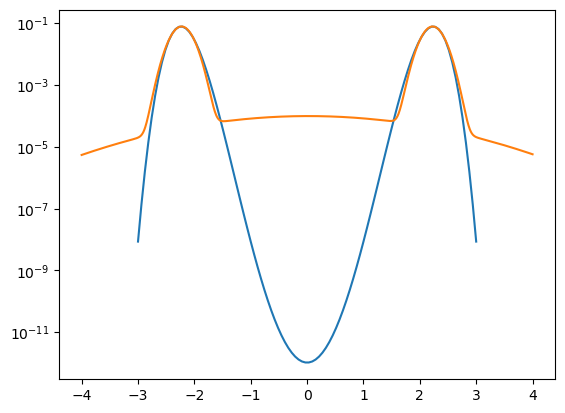

In [47]:
def weight_rc(rc, bg_muca, T):
        energy_rc = bg_muca._target._a * rc + bg_muca._target._b * rc.pow(2) + bg_muca._target._c * rc.pow(4)
        return (-energy_rc/T).exp()
rcs = torch.linspace(-3,3,100)
dist = weight_rc(rcs, bg_muca, T) / weight_rc(rcs, bg_muca, T).sum()
plt.plot(rcs, dist)

N = 4
args = np.ravel([np.random.choice(xs, size=N), np.ones(N), np.full(N,1/N)])
args = fit_gmm(assert_numpy(rcs), assert_numpy(dist)[:-1], N, args)
print(args)

xs = np.linspace(-4,4,1000)
ys = GMM_for_numpy(xs,N,args)
plt.plot(xs,ys)
plt.yscale('log')

In [15]:
# training without sampling (different from example but similar to 2019 paper)
size_batch = 100
optim = torch.optim.Adam(bg_muca.parameters(), lr=5e-3)
n_epochs = 5
n_report_steps = 50
n_samples = 1000

n_batches = 1000

n_samples_muca = 10000

T = 1

xs = np.linspace(-4,4,100)
gmms = []
hists = []
rhists = []

N = 4
args = np.ravel([np.zeros(N), np.ones(N), np.full(N,1/N)])
# start with stable solution
rcs = torch.linspace(-3,3,100)
dist = weight_rc(rcs, bg_muca, T) / weight_rc(rcs, bg_muca, T).sum()
args = fit_gmm(assert_numpy(rcs), assert_numpy(dist)[:-1], N, args)

values = GMM_for_numpy(xs,N,args)
gmms.append(values)

reporter = LossReporter("NLL")
for epoch in range(n_epochs):
    for it in range(n_batches):
        def muca_kldiv(x, dlogp, args):
            kldiv = 0
            kldiv -= boltzmann(target._energy(*x),T)
            kldiv -= -box(*x)
            kldiv -= muca(get_rc(*x), args)
            kldiv -= dlogp
            return kldiv

        # start by sampling manually 
        # (used for both weight update and training)
        z = bg_muca.prior.sample(n_samples)
        z = pack_tensor_in_tuple(z)
        *x, dlogp = bg_muca.flow(*z)

        # in fact, we may want this to be the inverse of the probability distribution
        #weight_params = estimate_inverse_distribution(bg,x,z,dlogp,weight_params)
        #weights.append(weight_params)

        # training
        optim.zero_grad()

        # kl divergence to the target
        kll = muca_kldiv(x, dlogp, [N,*args]).mean()

        # aggregate weighted gradient
        kll.backward()
        
        reporter.report(kll)
        
        optim.step()
        
        if it % n_report_steps == 0:
            print("\repoch: {0}, iter: {1}/{2}, KL: {3:.4}".format(
                    epoch,
                    it,
                    n_batches,
                    *reporter.recent(1).ravel()
                ), end="") 
    # weight update (evtl. module)

    z = bg_muca.prior.sample(n_samples_muca)
    z = pack_tensor_in_tuple(z)
    *x, dlogp = bg_muca.flow(*z)
    print(epoch, "", log_likelihood(x,bg_muca,T,[N,*args]))

    fit = True
    if fit:
        samples = assert_numpy(*x)
        hist, bins = np.histogram(samples[:,0], 100, density=True)
        hist_reweight = hist*GMM_for_numpy(bins[:-1], N, args)
        args = fit_gmm(bins, hist_reweight, N, args)
        print(args)
        values = GMM_for_numpy(xs,N,args)
        gmms.append(values)
        hists.append((bins,hist))
        rhists.append((bins,hist_reweight))
    else:
        pass

   


NameError: name 'weight_rc' is not defined

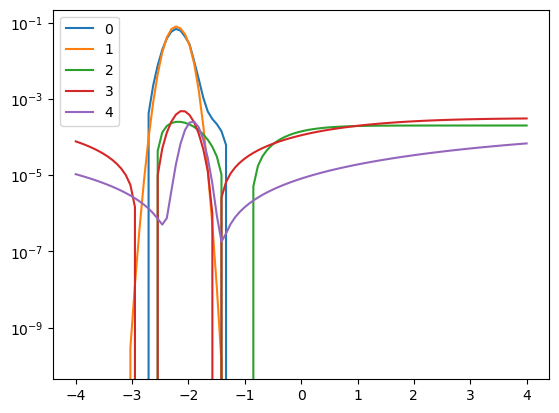

In [ ]:
plt.yscale('log')
for i in range(n_epochs):
    plt.plot(xs,gmms[i], label=i)
plt.legend()

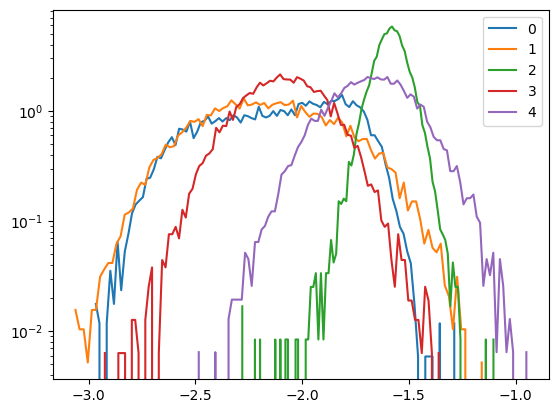

In [ ]:
plt.yscale('log')
for i in range(n_epochs):
    bins,hist = hists[i]
    plt.plot(bins[:-1],hist,label=i)
plt.legend()


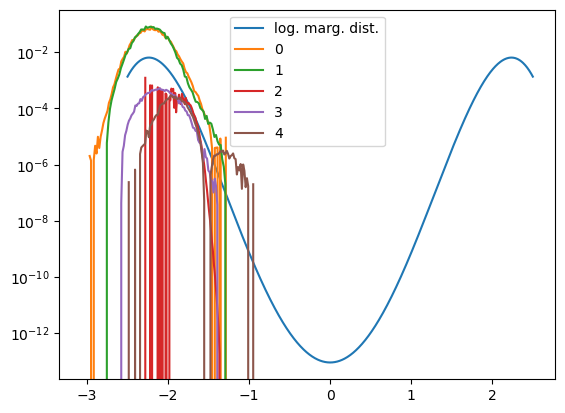

In [ ]:
plt.yscale('log')
rcs = torch.linspace(-2.5,2.5,1000)
plt.plot(rcs,assert_numpy((weight_rc(rcs, bg_muca, T) / weight_rc(rcs, bg_muca, T).sum())), label='log. marg. dist.')
for i in range(n_epochs):
    bins,hist = rhists[i]
    plt.plot(bins[:-1],hist,label=i)
plt.legend()

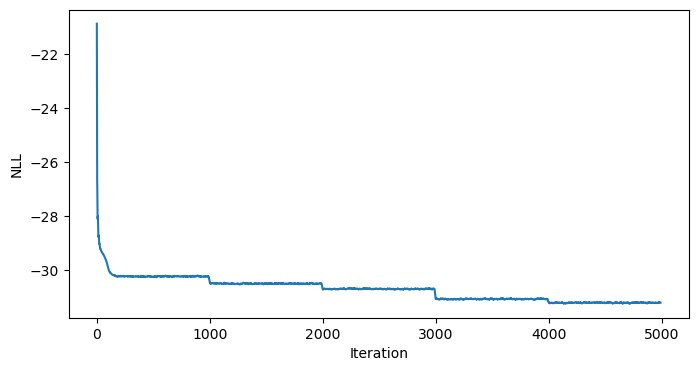

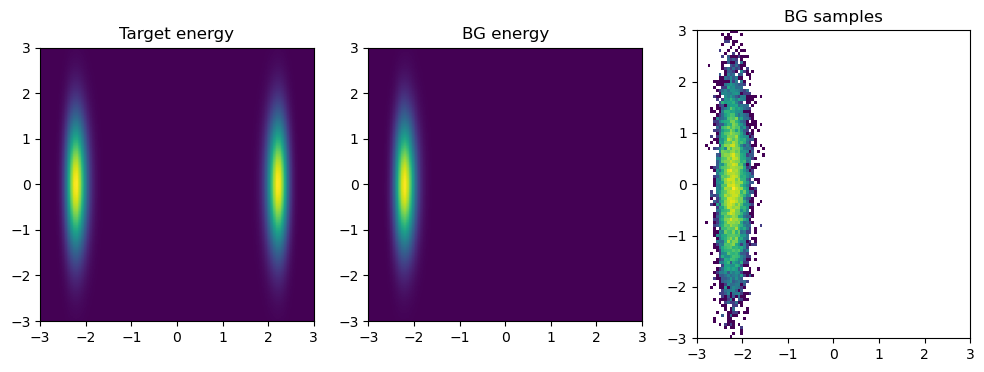

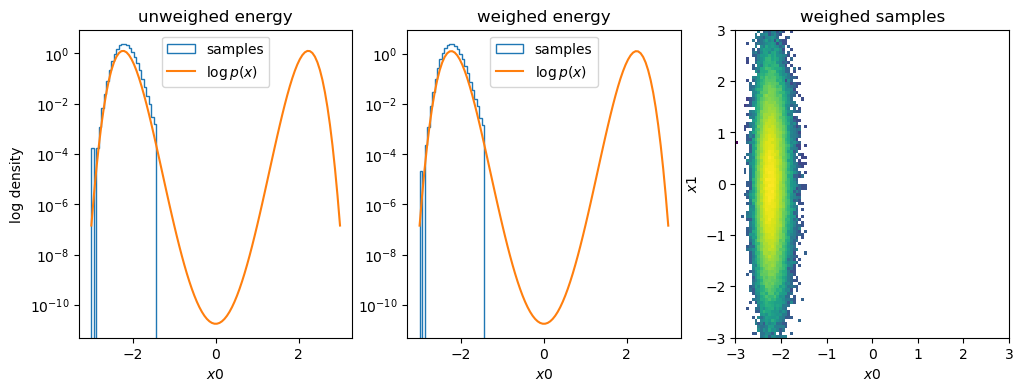

In [ ]:
reporter.plot()

plot_bg(bg_muca, target, dim=dim)

plot_weighted_energy_estimate(bg_muca, target, dim=dim)

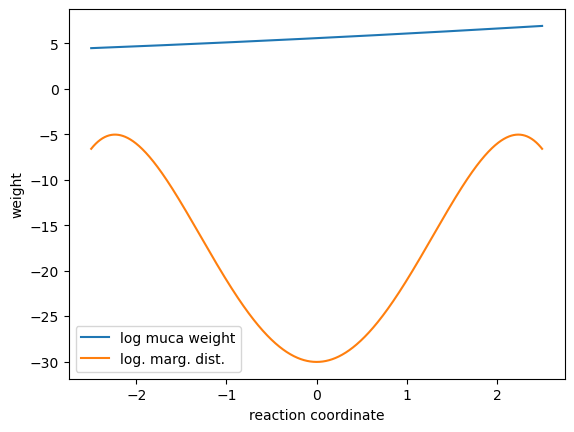

In [ ]:
def weight_rc(rc, bg_muca, T):
        energy_rc = bg_muca._target._a * rc + bg_muca._target._b * rc.pow(2) + bg_muca._target._c * rc.pow(4)
        return (-energy_rc/T).exp()

T = 1
rcs = torch.linspace(-2.5,2.5,1000)
plt.plot(rcs,assert_numpy(muca(rcs, [N, *args])), label='log muca weight')
plt.plot(rcs,assert_numpy((weight_rc(rcs, bg_muca, T) / weight_rc(rcs, bg_muca, T).sum()).log()), label='log. marg. dist.')
plt.ylabel('weight')
plt.xlabel('reaction coordinate')
plt.legend()